## West Nile Virus Prediction
*Predict West Nile virus in mosquitos across the city of Chicago*

**Dataset:** https://www.kaggle.com/c/predict-west-nile-virus

**Problem statement:** 
Track the regions with the highest concentration of West Nile Viral mosquito vectors & predict potential outbreak. 

**Approach:**
- Track mosquitos population in summer months 
- Look into species of Wnv carrier
- Look into hot and wet conditions (suitable for vector breeding) 
- Look into longitude and latitude to determine the areas with potential outbreak.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import datetime

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection;
from sklearn import metrics;
from sklearn.metrics import make_scorer;
from sklearn.dummy import DummyClassifier;
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV, Ridge;  
from sklearn.feature_selection import SelectKBest, chi2, f_classif;
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV;
from sklearn import linear_model;
from sklearn.svm import SVC;
from sklearn.tree import DecisionTreeClassifier

import matplotlib;
import matplotlib.pyplot as plt;

import seaborn as sns;

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Reading the Data  
4 datasets available:
1. Train Data
2. Test Data
3. Spray Data
4. Weather Data

In [2]:
traindf = pd.read_csv('./data/west_nile/input/train.csv')
testdf = pd.read_csv('./data/west_nile/input/test.csv')
weatherdf = pd.read_csv('./data/west_nile/input/weather.csv')
spraydf = pd.read_csv('./data/west_nile/input/spray.csv')
traindf.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

## Cleaning Weather Data
Assumption: Mosquitoes thrive in hot and wet conditions. As such, we're only interested in whether the weather is hot/cold or wet/dry. Other information will be dropped.

In [3]:
#Looking at weather data
weatherdf.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [4]:
#Filling in the missing values
weatherdf = weatherdf.replace('M', 0)
weatherdf = weatherdf.replace('-', 0)
weatherdf = weatherdf.replace('T', 0)
weatherdf = weatherdf.replace(' T', 0)
weatherdf = weatherdf.replace('  T', 0)

In [5]:
#Lifting the "Date", "Tavg" and "DewPoint" features into a new df and converting values to float
TrimmedWeatherdf = pd.DataFrame([weatherdf['Date'], weatherdf['Tavg'], weatherdf['DewPoint']]).T
TrimmedWeatherdf['DewPoint'] = TrimmedWeatherdf['DewPoint'].astype(float)
TrimmedWeatherdf['Tavg'] = TrimmedWeatherdf['Tavg'].astype(float)
TrimmedWeatherdf = TrimmedWeatherdf.groupby('Date')[['Tavg', 'DewPoint']].mean()

In [6]:
#Coding dummy variables for is_hot (1 for hot, 0 for not hot) and is_dry (1 for dry, 0 for wet)
#dewpoint < 55 is dry, > 55 is wet
#temperature < 65 is cold, >65 is hot
hot = []
dry = []

for c in TrimmedWeatherdf['Tavg']:
    if c > 65:
        hot.append(1)
    else:
        hot.append(0)
        
for c in TrimmedWeatherdf['DewPoint']:
    if c > 55:
        dry.append(1)
    else:
        dry.append(0)
        
TrimmedWeatherdf['is_hot'] = hot
TrimmedWeatherdf['is_dry'] = dry

hotanddrydf = TrimmedWeatherdf.drop(['Tavg', 'DewPoint'], axis=1).reset_index()

In [7]:
hotanddrydf.head()

,Date,is_hot,is_dry
0,2007-05-01,1,0
1,2007-05-02,0,0
2,2007-05-03,0,0
3,2007-05-04,0,0
4,2007-05-05,0,0


## Cleaning Spray data

In [8]:
#looking at Spray Data
spraydf.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [9]:
#Spraydf will be added to our train and test dataset later as dummy variables. 
#'Time' is not needed, to be replaced with '1'
spraydf['Spray'] = spraydf['Time'].apply(lambda x: 1)
spraydf = spraydf.drop('Time', axis=1)
spraydf.head()

,Date,Latitude,Longitude,Spray
0,2011-08-29,42.391623,-88.089163,1
1,2011-08-29,42.391348,-88.089163,1
2,2011-08-29,42.391022,-88.089157,1
3,2011-08-29,42.390637,-88.089158,1
4,2011-08-29,42.390410,-88.088858,1


## Cleaning Train and Test data

In [10]:
#Taking a look at train data
traindf.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [11]:
#Taking a look at test data
testdf.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [12]:
traindf['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [13]:
testdf['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [14]:
#For train data
#Location info will be represented solely by Longitude and Latitude. All other location info will be dropped.
traindf = traindf[['Date','Species','Latitude','Longitude','NumMosquitos','WnvPresent']]
traindf.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0


In [15]:
def carrier (dataset): 
    carrier = []
    for i in dataset['Species']:
        if i == 'CULEX PIPIENS/RESTUANS':
            carrier.append(1)
        elif i == 'CULEX RESTUANS':
            carrier.append(1)
        elif i == 'CULEX PIPIENS':
            carrier.append(1)
        else:
            carrier.append(0)
    return carrier 
        
traindf['carrier'] = carrier(traindf)
testdf['carrier'] = carrier(testdf)

In [16]:
traindf.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,carrier
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,1
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,1


In [17]:
traindf = traindf.loc[traindf.carrier == 1]

In [18]:
#For test data
#Location info will be represented solely by Longitude and Latitude. All other location info will be dropped.
testdf = testdf[['Id','Date','Species','Latitude','Longitude', 'carrier']]
testdf.head()

,Id,Date,Species,Latitude,Longitude,carrier
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,1
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,1
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,1
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,0
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,0


In [19]:
#Appending new DataFrame with species information vs location, for use in EDA later.
#Because the next cell will drop 'Species' from the main dataset.
train_Species_loc = traindf[['Species','Latitude','Longitude']]
test_Species_loc = testdf[['Species','Latitude','Longitude']]

In [20]:
#Converting 'Species' to dummy variables.
#drop_first=True should drop CULEX PIPIENS/RESTUANS as our reference category
#traindf = traindf.join(pd.get_dummies(traindf['Species'])).drop('Species',axis=1)
#testdf = testdf.join(pd.get_dummies(testdf['Species'])).drop('Species',axis=1)

In [21]:
traindf.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,carrier
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,1
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,1


In [22]:
testdf.head()
#test data has a species 'UNSPECIFIED CULEX' not present in the train data.
#'UNSPECIFIED CULEX' will be treated as reference category and dropped.

,Id,Date,Species,Latitude,Longitude,carrier
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,1
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,1
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,1
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,0
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,0


## Merging the spray data and weather data with the train and test data

In [23]:
#Merging hotanddrydf to traindf and test df
traindf = traindf.merge(hotanddrydf, how='left', on='Date')
testdf = testdf.merge(hotanddrydf, how='left', on='Date')

In [24]:
testdf

,Id,Date,Species,Latitude,Longitude,carrier,is_hot,is_dry
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,1,1
1,2,2008-06-11,CULEX RESTUANS,41.954690,-87.800991,1,1,1
2,3,2008-06-11,CULEX PIPIENS,41.954690,-87.800991,1,1,1
3,4,2008-06-11,CULEX SALINARIUS,41.954690,-87.800991,0,1,1
4,5,2008-06-11,CULEX TERRITANS,41.954690,-87.800991,0,1,1
5,6,2008-06-11,CULEX TARSALIS,41.954690,-87.800991,0,1,1
6,7,2008-06-11,UNSPECIFIED CULEX,41.954690,-87.800991,0,1,1
7,8,2008-06-11,CULEX ERRATICUS,41.954690,-87.800991,0,1,1
8,9,2008-06-11,CULEX PIPIENS/RESTUANS,41.994991,-87.769279,1,1,1
9,10,2008-06-11,CULEX RESTUANS,41.994991,-87.769279,1,1,1


In [25]:
#Changing Date to datetime format
traindf['Date'] = pd.to_datetime(traindf['Date'])
testdf['Date'] = pd.to_datetime(testdf['Date'])
print(traindf.dtypes)
print(testdf.dtypes)

Date            datetime64[ns]
Species                 object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
carrier                  int64
is_hot                   int64
is_dry                   int64
dtype: object
Id                    int64
Date         datetime64[ns]
Species              object
Latitude            float64
Longitude           float64
carrier               int64
is_hot                int64
is_dry                int64
dtype: object


## EDA  
For fulfilling the spirit of this exercise, EDA will be run on train data only

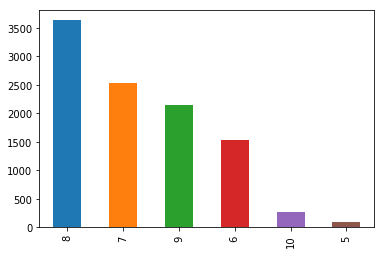

In [26]:
traindf['Date'].dt.month.value_counts().plot(kind='bar')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


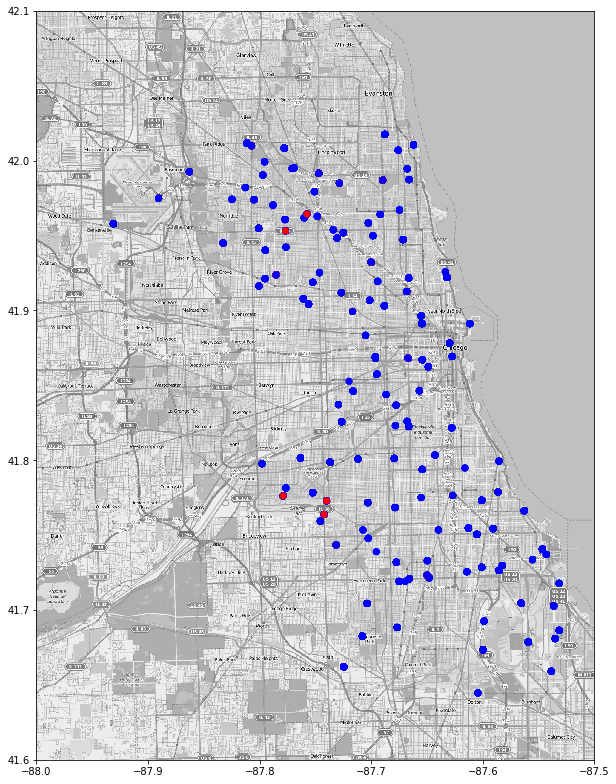

In [27]:
#plotting map of west nile virus outbreaks
mapdata = np.loadtxt("./data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
virus_data = traindf[['Latitude','Longitude','WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

present = {1:'red',0:'blue'}
virus_data['p_colors'] = virus_data['WnvPresent'].apply(lambda x: present[x])

plt.scatter(virus_data['Longitude'], virus_data['Latitude'], c=virus_data['p_colors'], marker='o')



### Comments  
_Outbreak of west nile virus is highly localized._

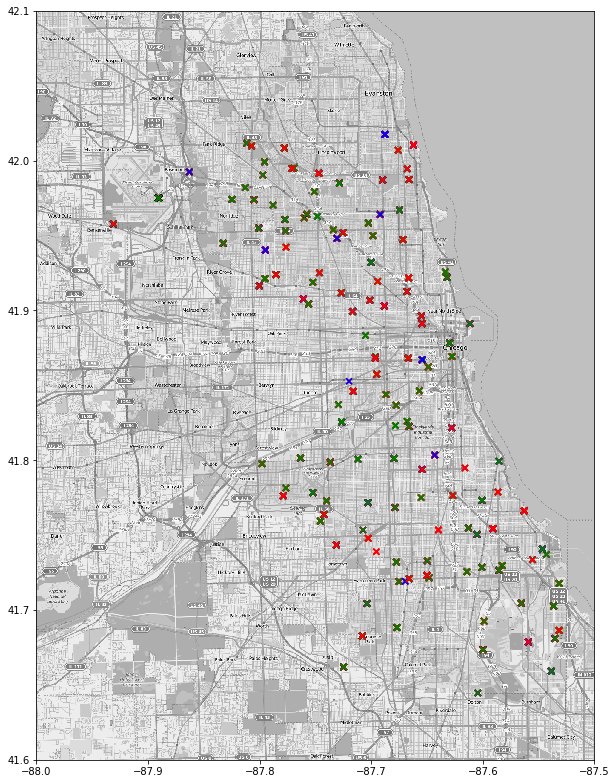

In [28]:
#plotting species of mosquitoes
species_data = train_Species_loc

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

colors={'CULEX PIPIENS/RESTUANS':'red', 'CULEX RESTUANS':'blue', 'CULEX PIPIENS':'green', 'CULEX SALINARIUS':'purple', 'CULEX TERRITANS':'yellow', 'CULEX TARSALIS':'orange','CULEX ERRATICUS':'brown'}
species_data['colors'] = species_data['Species'].apply(lambda x: colors[x])

plt.scatter(species_data['Longitude'], species_data['Latitude'], c=species_data['colors'], marker='x')


### Comments  
Mosquitoes are most active during month 8 (i.e. August)

## Splitting into predictor and target matrices

In [29]:
#Training Data
y_train = traindf['WnvPresent'].values
X_train = traindf.drop(['WnvPresent','NumMosquitos', 'Species', 'Date'], axis=1) #Note: 'NumMosquitos' not in test data. Dropping it here to match.
X_train

,Latitude,Longitude,carrier,is_hot,is_dry
0,41.954690,-87.800991,1,1,1
1,41.954690,-87.800991,1,1,1
2,41.994991,-87.769279,1,1,1
3,41.974089,-87.824812,1,1,1
4,41.974089,-87.824812,1,1,1
5,41.921600,-87.666455,1,1,1
6,41.891118,-87.654491,1,1,1
7,41.867108,-87.654224,1,1,1
8,41.867108,-87.654224,1,1,1
9,41.896282,-87.655232,1,1,1


In [30]:
X_test = testdf.drop(['Id', 'Species', 'Date'], axis=1).copy()

In [31]:
X_test

,Latitude,Longitude,carrier,is_hot,is_dry
0,41.954690,-87.800991,1,1,1
1,41.954690,-87.800991,1,1,1
2,41.954690,-87.800991,1,1,1
3,41.954690,-87.800991,0,1,1
4,41.954690,-87.800991,0,1,1
5,41.954690,-87.800991,0,1,1
6,41.954690,-87.800991,0,1,1
7,41.954690,-87.800991,0,1,1
8,41.994991,-87.769279,1,1,1
9,41.994991,-87.769279,1,1,1


## Applying models
1. Random Forest
2. Logistic Regression

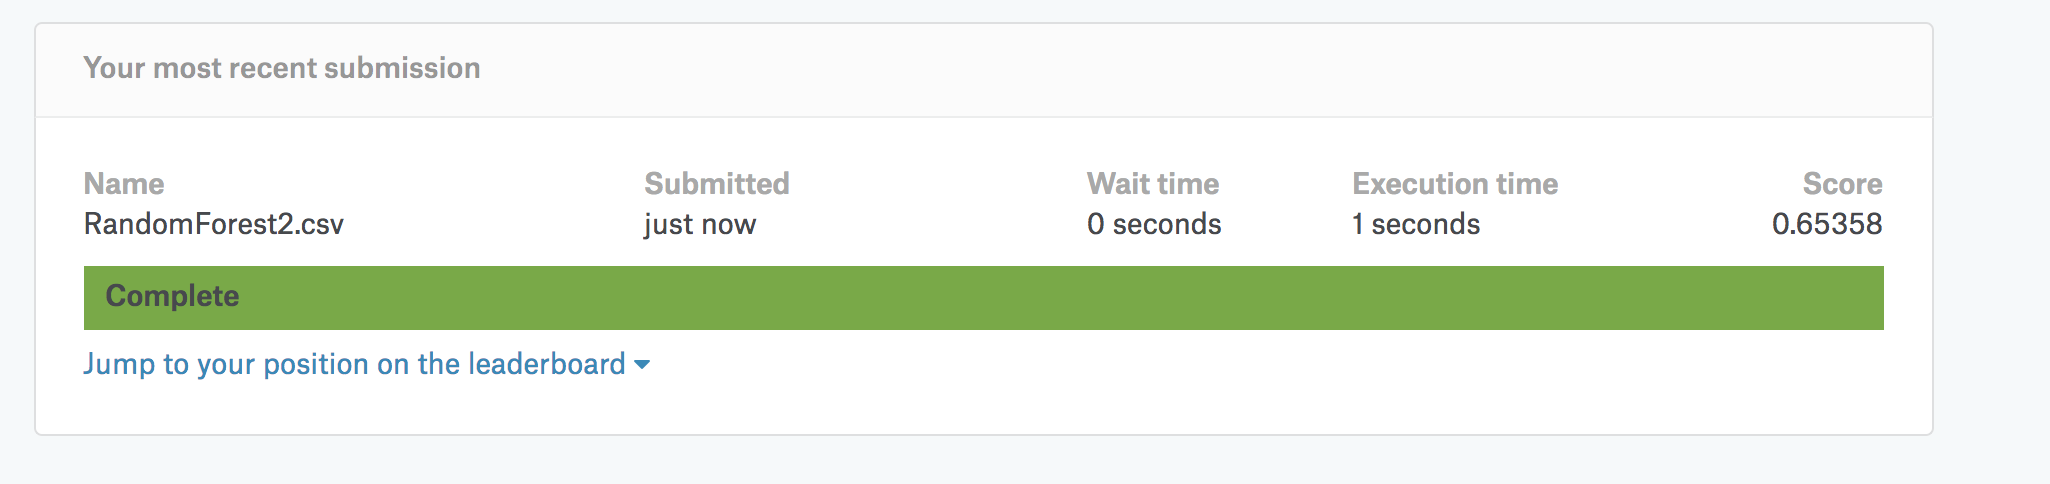

In [32]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
# create predictions and submission file
predictions = pd.DataFrame(np.array(clf.predict_proba(X_test))[:,0])

In [34]:
predictions

,0
0,0.858853
1,0.858853
2,0.858853
3,0.858853
4,0.858853
5,0.858853
6,0.858853
7,0.858853
8,1.000000
9,1.000000


In [35]:
df = pd.concat([testdf['Id'], predictions], axis=1)

In [36]:
df.shape

(116293, 2)

In [37]:
df = df.rename(columns={0:'WnvPresent'})

In [38]:
df = df.set_index('Id')

In [39]:
df.to_csv('RandomForest5.csv')

### LRCV

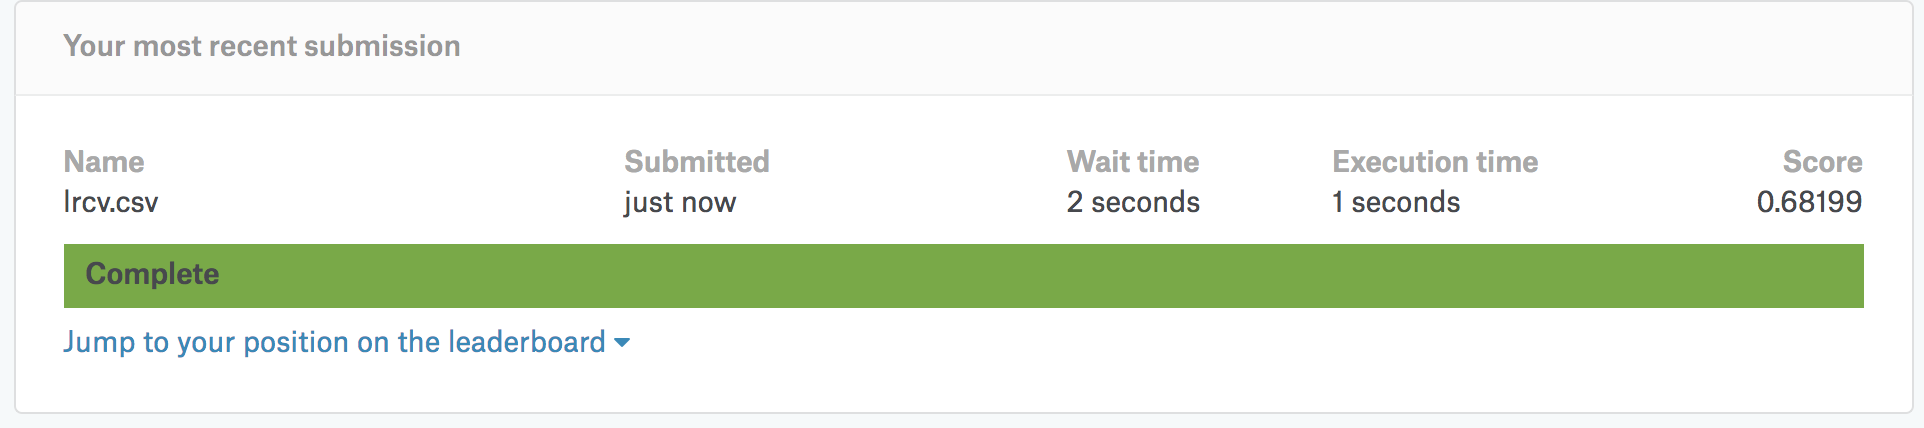

In [40]:
ss = StandardScaler()
lr = LogisticRegression()

In [41]:
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [42]:
lrcv = LogisticRegressionCV(cv=10).fit(Xs_train, y_train)
y_pred_lrcv = lrcv.predict_proba(Xs_test)[:,1]
y_pred_lrcv 

array([0.05644645, 0.05644645, 0.05644645, ..., 0.05496668, 0.05496668,
       0.05496668])

In [43]:
lrcv = pd.DataFrame(testdf['Id'])
lrcv['WnvPresent'] = y_pred_lrcv
lrcv.set_index('Id', inplace=True)
lrcv.to_csv('lrcv.csv')